# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import janitor as jn

from seaborn import diverging_palette

In [2]:
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)
from yellowbrick.model_selection import (
    LearningCurve 
)

from imblearn.over_sampling import (
    SMOTE, ADASYN
)

# Load dataset

In [3]:
import pandas as pd

df = pd.read_csv('bank_marketing_dataset.csv')
df.head(5)

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  subscribed  
0          93.994          -36.4      4.857       5191.0          no  
1          93.994          -36.4      4.857       5191.0          no  
2          93.994          -36.4      4.857       5191.0          no  
3          93.994          -36.4      4.857       5191.0          no  
4          93.994          -36.4      4.857       5191.0          no  

[5 rows x 21 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Create the target

In [5]:
target = [
    1 if i == 'yes'
    else 0
    for i in df['subscribed']
]

df['target'] = target
df['target'].value_counts()

0    36548
1     4640
Name: target, dtype: int64

In [6]:
df.drop('subscribed', axis=1, inplace=True)

# Data clean up

In [7]:
df.drop(['duration'],
        axis=1,
        inplace=True)

# this attribute highly affects the output target (e.g., if duration=0 then y='no'). 

### Correlations

In [8]:
numerical_cols_c = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

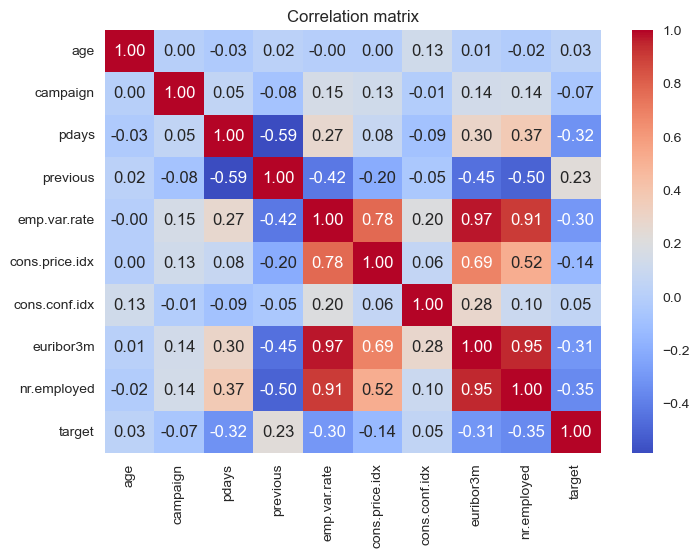

In [9]:
# Correlation matrix
corr = df[numerical_cols_c].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [10]:
# nr.employed, euribor3m and emp.var.rate are all highly correlated. Let's only keep nr.employed
df = df.drop(columns=['euribor3m', 'emp.var.rate'])

# Categorical encoding

In [11]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
numeric_cols

Index(['age', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'target'],
      dtype='object')

In [12]:
categorical_cols = df.select_dtypes(include=["object"]).columns
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

### Label encode for categories that have less than two values

In [13]:
from sklearn import preprocessing

count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print(col)

print('%d columns were label encoded.' % count)

contact
1 columns were label encoded.


Now, contact = 1 if telephone and 0 if cellular

### One-hot encoding the rest of categorical columns

In [14]:
df = pd.get_dummies(df)
print(df.shape)

(41188, 60)


In [15]:
for col in df.columns:
    print(col)

age
contact
campaign
pdays
previous
cons.price.idx
cons.conf.idx
nr.employed
target
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
marital_divorced
marital_married
marital_single
marital_unknown
education_basic.4y
education_basic.6y
education_basic.9y
education_high.school
education_illiterate
education_professional.course
education_university.degree
education_unknown
default_no
default_unknown
default_yes
housing_no
housing_unknown
housing_yes
loan_no
loan_unknown
loan_yes
month_apr
month_aug
month_dec
month_jul
month_jun
month_mar
month_may
month_nov
month_oct
month_sep
day_of_week_fri
day_of_week_mon
day_of_week_thu
day_of_week_tue
day_of_week_wed
poutcome_failure
poutcome_nonexistent
poutcome_success


## Seperate features and target

In [16]:
#pip install pyjanitor
import janitor as jn

In [17]:
X, y = jn.ml.get_features_targets(df, target_columns="target")

c:\Users\olivi\anaconda3\lib\site-packages\janitor\utils.py:365: DeprecationWarning: target_columns is deprecated; use target_column_names
  warn(


## Train test split

In [18]:
X_train, X_val_test, y_train, y_val_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [19]:
print(len(X_train))
print(len(X_val_test))
print(len(y_train))
print(len(y_val_test))

28831
12357
28831
12357


## Test validation split

In [20]:
X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42)

In [21]:
print(len(X_val))
print(len(X_test))
print(len(y_val))
print(len(y_test))

6178
6179
6178
6179


# Baseline Model - DummyClassifier

Unbalanced, not standardized

In [22]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

In [23]:
# accuracy
print('accuracy:')
print(dummy_clf.score(X_val, y_val)) 

# precision
from sklearn import metrics
print('precision:')
print(metrics.precision_score(y_val, dummy_clf.predict(X_val)))

accuracy:
0.8870184525736484
precision:
0.0


c:\Users\olivi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
from sklearn.metrics import confusion_matrix

# Predict on the test set
y_pred = dummy_clf.predict(X_val)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5480    0]
 [ 698    0]]


# Standardize data

In [25]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Evaluation Metrics

### ROC Curve

In [26]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [27]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

In [28]:
from sklearn.metrics import fbeta_score

def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif not train:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)

        # Calculate and print F2 score
        f2_score = fbeta_score(y_val, clf.predict(X_val), beta=2)
        print("F2 score (beta=2): {0:.4f}\n".format(f2_score))

        print("End of validation Result\n")

### Classification Metrics

In [29]:
def evaluation_metrics(y_actual, y_pred):
            
        precision, recall, _ = precision_recall_curve(y_actual, y_pred)
        average_precision = average_precision_score(y_actual, y_pred)
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        roc_auc = roc_auc_score(y_actual, y_pred)
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_actual, y_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_actual, y_pred)))

# Balance target variable

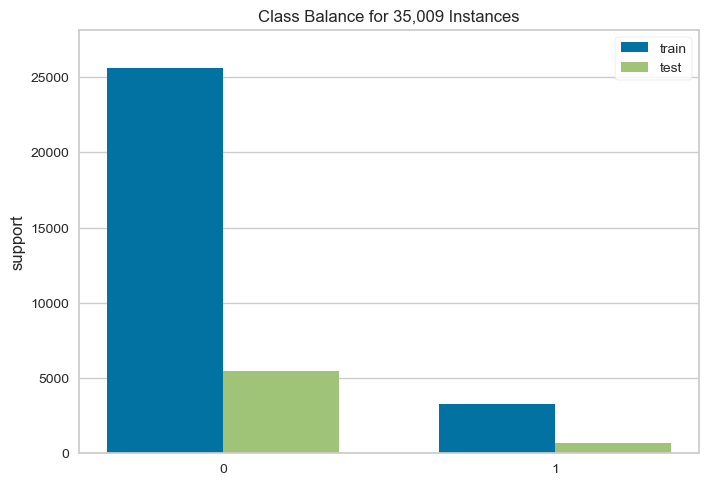

<Axes: title={'center': 'Class Balance for 35,009 Instances'}, ylabel='support'>

In [30]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Up-sample the training data

In [31]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

c:\Users\olivi\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\olivi\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


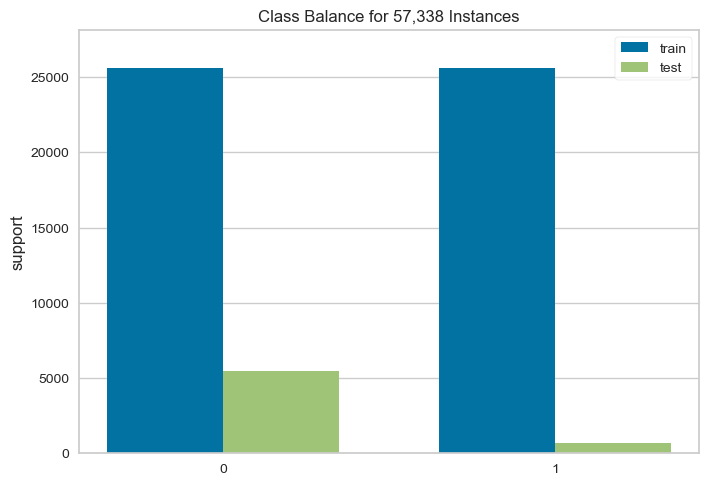

<Axes: title={'center': 'Class Balance for 57,338 Instances'}, ylabel='support'>

In [32]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train_sm, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# XGBoost

In [33]:
#!pip install xgboost 
import xgboost as xgb

Validation Result:

accuracy score: 0.8983



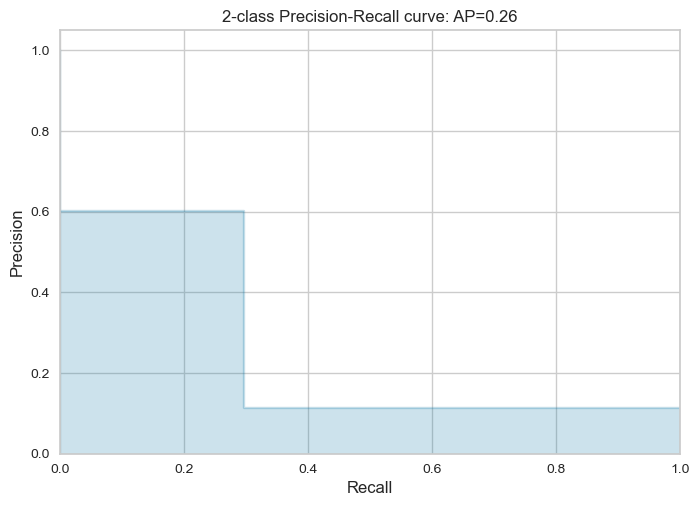

roc auc score: 0.6364058937945747



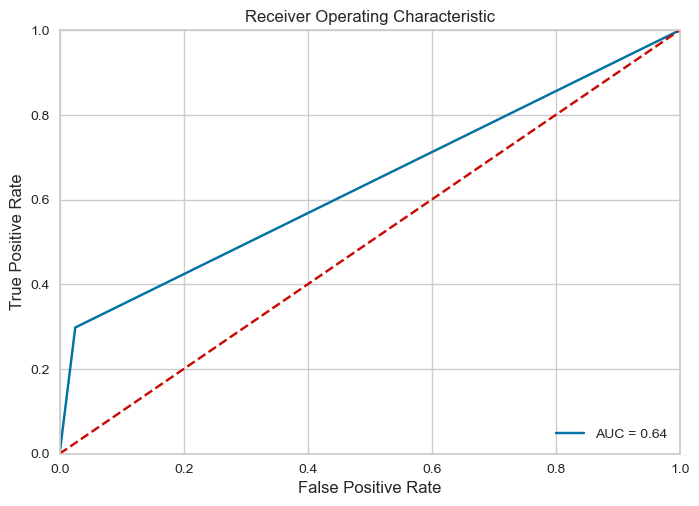

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      5480
           1       0.60      0.30      0.40       698

    accuracy                           0.90      6178
   macro avg       0.76      0.64      0.67      6178
weighted avg       0.88      0.90      0.88      6178


Confusion Matrix: 
 [[5342  138]
 [ 490  208]]

End of validation Result



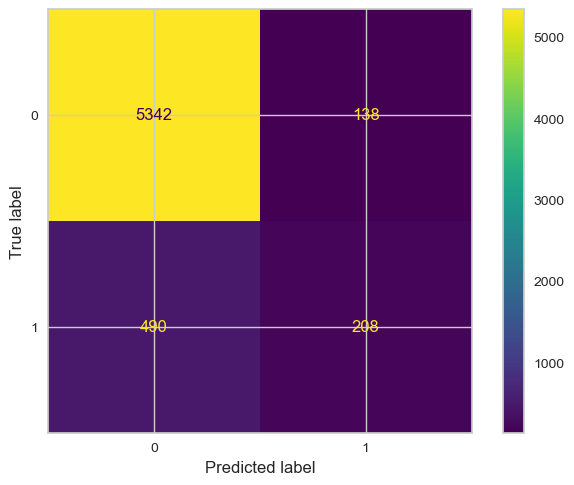

In [34]:
clf_xgb = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0)
clf_xgb.fit(X_train_sm, y_train_sm)

clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)

# Hyperparameter tuning - Optuna

In [80]:
#!pip install optuna

   ---------------------------------------- 0.0/380.1 kB ? eta -:--:--
   ------------------ -------------------- 184.3/380.1 kB 11.6 MB/s eta 0:00:01
   ---------------------------------------  378.9/380.1 kB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 380.1/380.1 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.4 kB ? eta -:--:--
   ------------------------------------- - 225.3/233.4 kB 13.4 MB/s eta 0:00:01
   ---------------------------------------- 233.4/233.4 kB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.8 kB ? eta -:--:--
   ---------------------------------------- 78.8/78.8 kB 4.3 MB/s eta 0:00:00


In [81]:
import optuna
from sklearn.metrics import accuracy_score

In [82]:
def objective(trial):
    params = {
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42
    }
    
    # Train XGBoost classifier with the suggested hyperparameters
    clf_xgb = xgb.XGBClassifier(**params)
    clf_xgb.fit(X_train_sm, y_train_sm)
    
    # Predict on the validation set and calculate accuracy
    y_val_pred = clf_xgb.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    return accuracy


In [83]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-04-24 22:38:18,048] A new study created in memory with name: no-name-3b3f58c9-03de-49e9-a15e-ef7da629bdab
[I 2024-04-24 22:38:27,617] Trial 0 finished with value: 0.887180317254775 and parameters: {'colsample_bytree': 0.1027931528554678, 'learning_rate': 0.11130056513429461, 'max_depth': 3, 'n_estimators': 91, 'subsample': 0.5245417950039206}. Best is trial 0 with value: 0.887180317254775.
[I 2024-04-24 22:38:31,558] Trial 1 finished with value: 0.8923599870508255 and parameters: {'colsample_bytree': 0.66622916945335, 'learning_rate': 0.07185299708171651, 'max_depth': 5, 'n_estimators': 135, 'subsample': 0.732921106058527}. Best is trial 1 with value: 0.8923599870508255.
[I 2024-04-24 22:38:32,788] Trial 2 finished with value: 0.8955972806733571 and parameters: {'colsample_bytree': 0.9909451780015147, 'learning_rate': 0.28247199298959114, 'max_depth': 4, 'n_estimators': 74, 'subsample': 0.73180475860554}. Best is trial 2 with value: 0.8955972806733571.
[I 2024-04-24 22:38:33,94

Best Hyperparameters: {'colsample_bytree': 0.15923028019084545, 'learning_rate': 0.11640424668386115, 'max_depth': 8, 'n_estimators': 175, 'subsample': 0.9207142760715115}


# Hyperparameter tuning - Bayesian Optimization

In [84]:
#!pip install bayesian-optimization

In [85]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score

In [88]:
# Define the objective function
def objective_function(colsample_bytree, learning_rate, max_depth, n_estimators, subsample):
    params = {
        'colsample_bytree': colsample_bytree,
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'random_state': 42
    }
    
    # Train XGBoost classifier with the suggested hyperparameters
    clf_xgb = xgb.XGBClassifier(**params)
    clf_xgb.fit(X_train_sm, y_train_sm)
    
    # Predict on the validation set and calculate accuracy
    y_val_pred = clf_xgb.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    return accuracy


In [89]:
# Define the search space
pbounds = {
    'colsample_bytree': (0.1, 1.0),
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'n_estimators': (50, 200),
    'subsample': (0.5, 1.0)
}


In [90]:
# Create the BayesianOptimization object
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42,
)

In [91]:
# Perform optimization
optimizer.maximize(
    init_points=10,  # Number of randomly chosen points to sample the target function before Bayesian optimization
    n_iter=100,      # Number of iterations of Bayesian optimization
)

# Get the best hyperparameters
best_params = optimizer.max['params']
print("Best Hyperparameters:", best_params)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.892     | 0.4371    | 0.2857    | 8.124     | 139.8     | 0.578     |
| 2         | 0.8943    | 0.2404    | 0.02684   | 9.063     | 140.2     | 0.854     |
| 3         | 0.8983    | 0.1185    | 0.2913    | 8.827     | 81.85     | 0.5909    |
| 4         | 0.8951    | 0.2651    | 0.09823   | 6.673     | 114.8     | 0.6456    |
| 5         | 0.8867    | 0.6507    | 0.05045   | 5.045     | 105.0     | 0.728     |
| 6         | 0.8945    | 0.8067    | 0.06791   | 6.6       | 138.9     | 0.5232    |
| 7         | 0.8869    | 0.6468    | 0.05945   | 3.455     | 192.3     | 0.9828    |
| 8         | 0.8919    | 0.8276    | 0.09834   | 3.684     | 152.6     | 0.7201    |
| 9         | 0.8998    | 0.2098    | 0.1536    | 3.241     | 186.4     | 0.6294    |
| 10        | 0.8985    | 0.6963    | 0.1004    | 6.64

# Best model: XGBoost from Optuna

Validation Result:

accuracy score: 0.9005



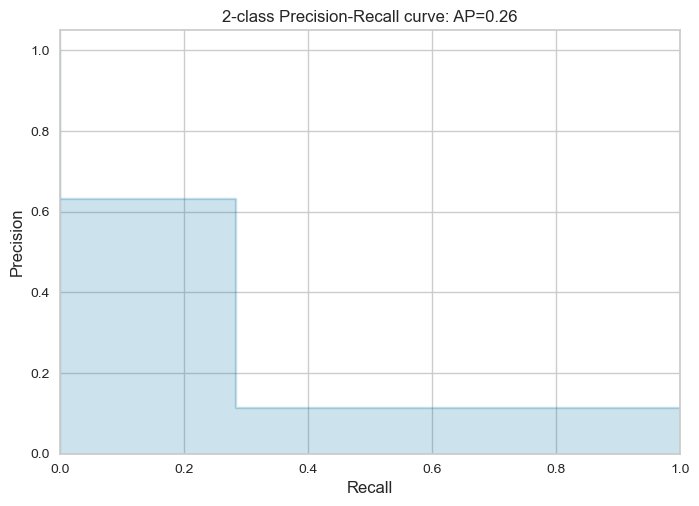

roc auc score: 0.6313411101583251



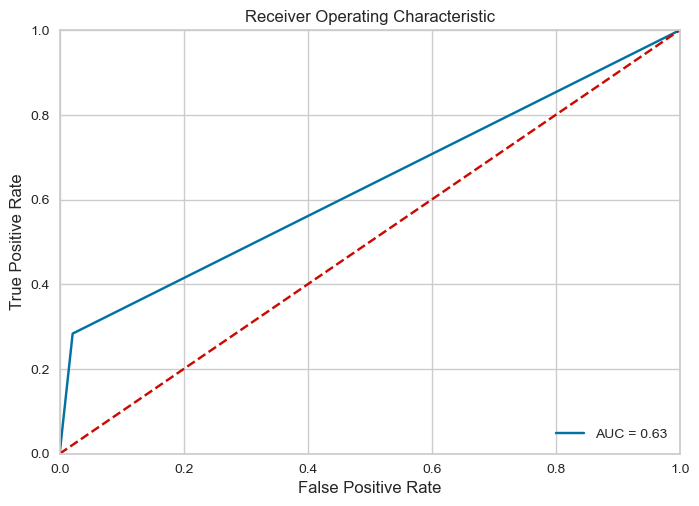

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      5480
           1       0.63      0.28      0.39       698

    accuracy                           0.90      6178
   macro avg       0.77      0.63      0.67      6178
weighted avg       0.88      0.90      0.88      6178


Confusion Matrix: 
 [[5365  115]
 [ 500  198]]

End of validation Result



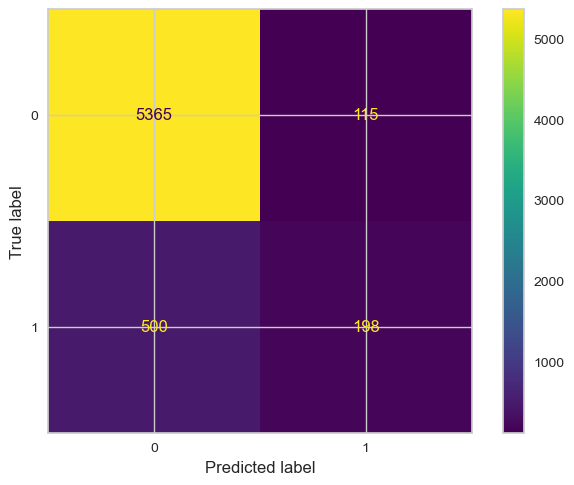

In [93]:
clf_xgb = xgb.XGBClassifier(colsample_bytree=0.15923028019084545, learning_rate=0.11640424668386115, max_depth=8, n_estimators=175, subsample=0.9207142760715115)
clf_xgb.fit(X_train_sm, y_train_sm)

clf_score(clf_xgb, X_train_sm, y_train_sm, X_val, y_val, train=False)


### Evaluate model on test set

In [94]:
from sklearn.metrics import accuracy_score, classification_report

y_test_pred = clf_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8948


#### Classification report

In [95]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5488
           1       0.56      0.27      0.37       691

    accuracy                           0.89      6179
   macro avg       0.74      0.62      0.65      6179
weighted avg       0.87      0.89      0.88      6179



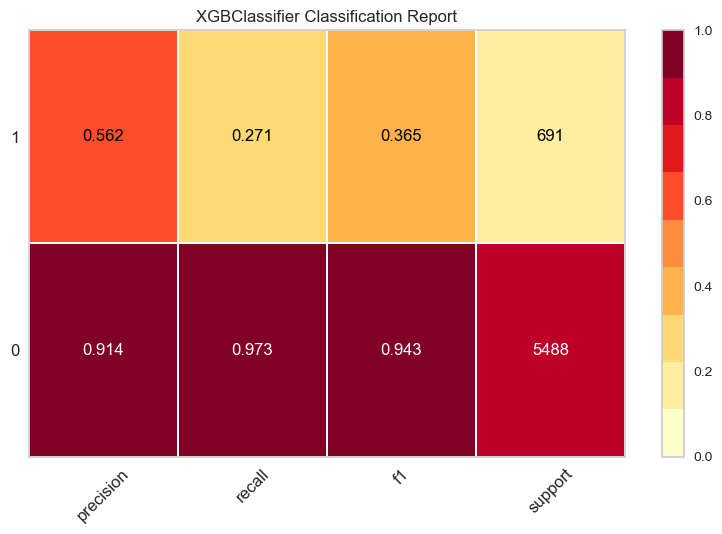

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [96]:
from yellowbrick.classifier import ClassificationReport

classes = ["0", "1"]

visualizer = ClassificationReport(
    clf_xgb, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Confusion matrix

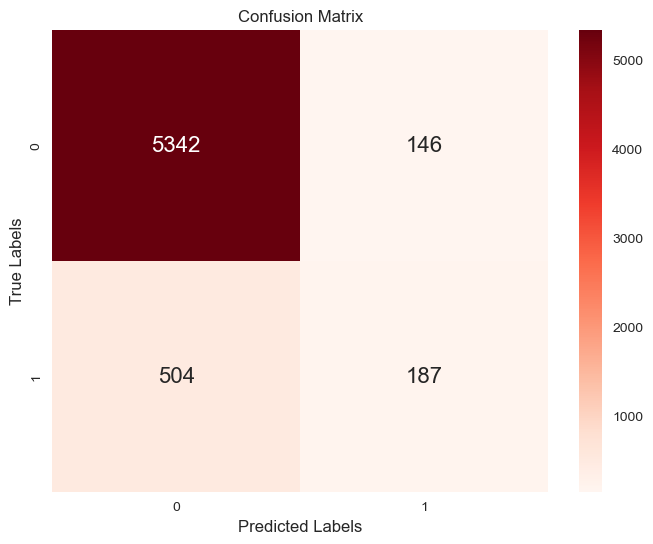

In [97]:
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### PR Curve

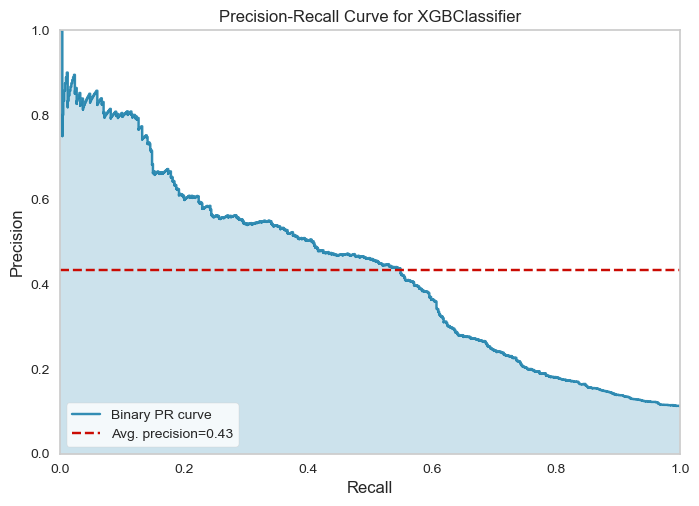

<Axes: title={'center': 'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [98]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_xgb, is_fitted=True)
viz.fit(X_train_sm, y_train_sm)
viz.score(X_test, y_test)
viz.show()

#### ROC-AUC

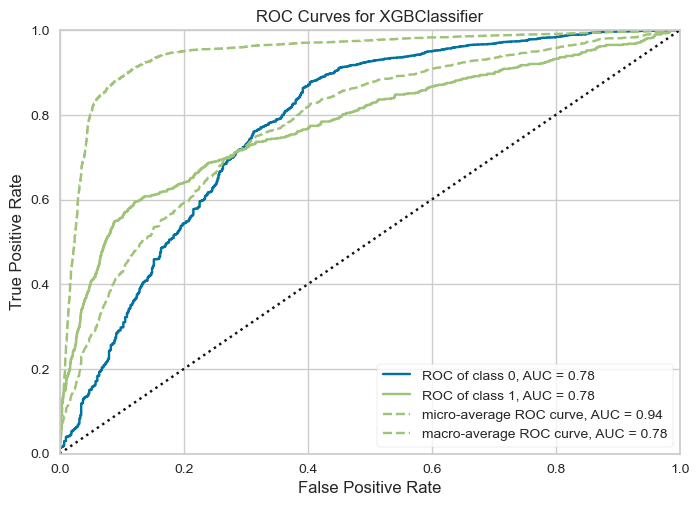

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [99]:
visualizer = ROCAUC(
    clf_xgb, classes=classes, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Validation curve

this method is deprecated, please use show() instead


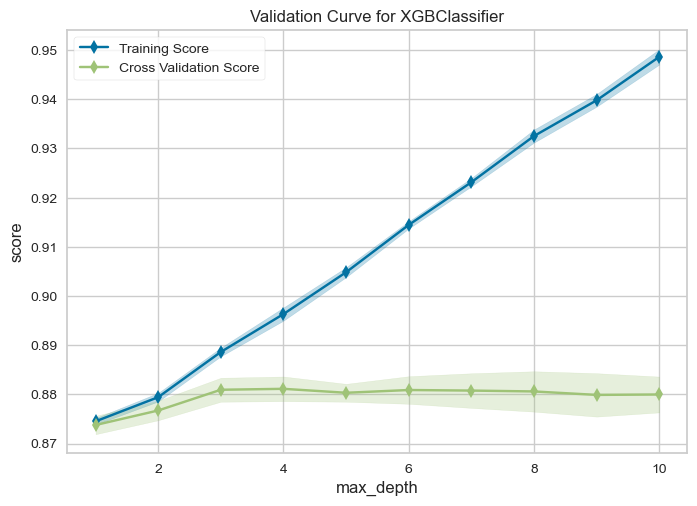

<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>

In [100]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0), 
    param_name="max_depth",
    param_range=np.arange(1, 11), 
    cv=5, 
    scoring="f1_weighted",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()

#### Learning curve

this method is deprecated, please use show() instead


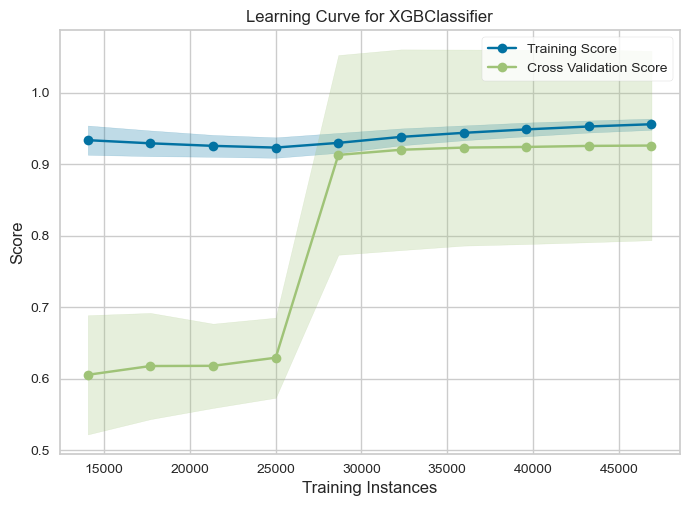

<Axes: title={'center': 'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [101]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer

visualizer = LearningCurve(
    xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, random_state=42, subsample=1.0), 
    cv=cv, 
    scoring='f1_weighted', 
    train_sizes=sizes, 
    n_jobs=8
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the data to the visualizer
visualizer.poof()                       # Finalize and render the figure

#### Discrimination Threshold

this method is deprecated, please use show() instead


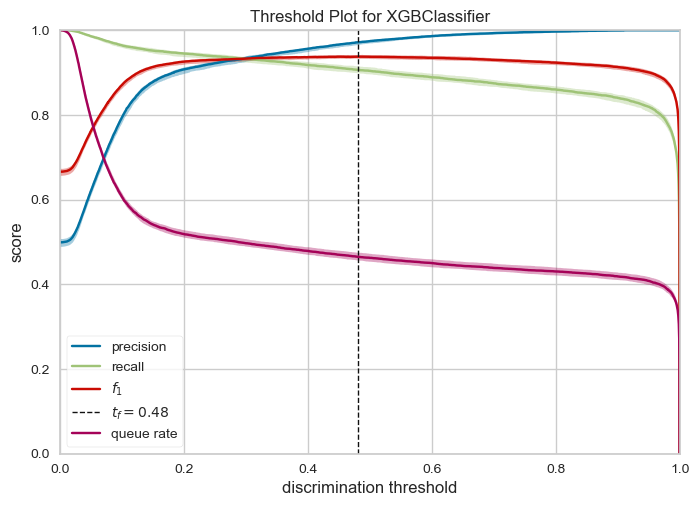

<Axes: title={'center': 'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [102]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(clf_xgb, is_fitted=True)

visualizer.fit(X_train_sm, y_train_sm)
visualizer.poof() 

#### Decision Function

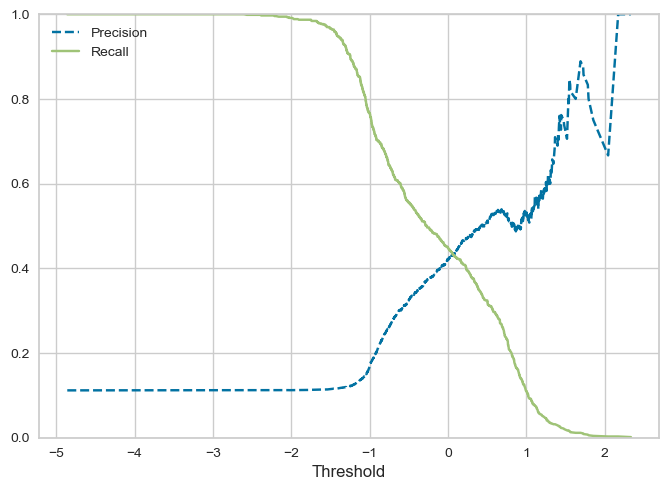

In [103]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve

clf_svc = SVC(gamma='auto')
clf_svc.fit(X_train_sm, y_train_sm)

# call decision_function on classifier to get scores (probas_pred)
probas_pred = clf_svc.decision_function(X_test)
# compute precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred)
# precision and recall vs. the decision threshold
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

#### Feature importance

<Axes: >

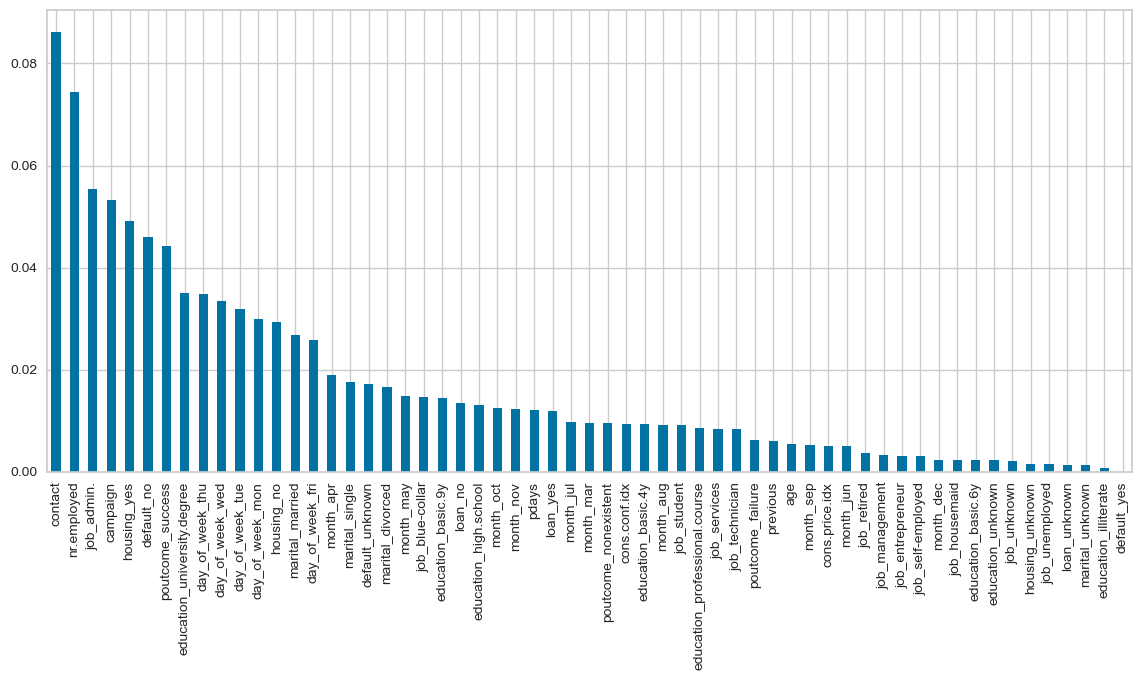

In [104]:
# Print feature importance
pd.Series(clf_xgb.feature_importances_,index = X.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (14,6))


In [105]:
#pip install shap


# Explainability - SHAP

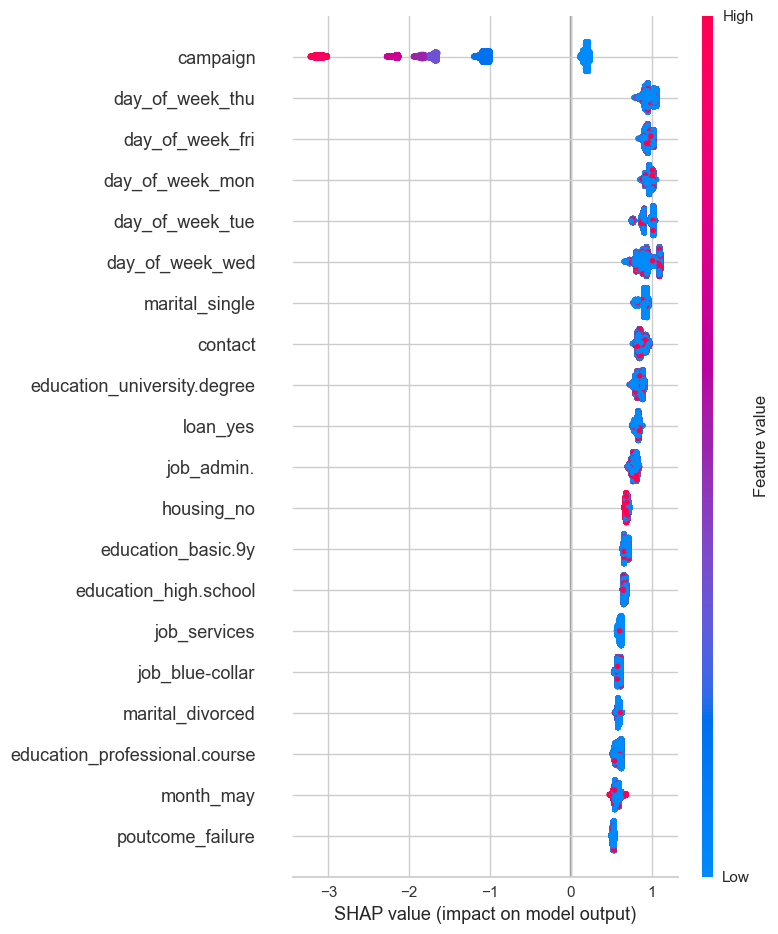

In [106]:
import shap

explainer = shap.Explainer(clf_xgb)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=X.columns)

 99%|===================| 6144/6178 [01:01<00:00]        

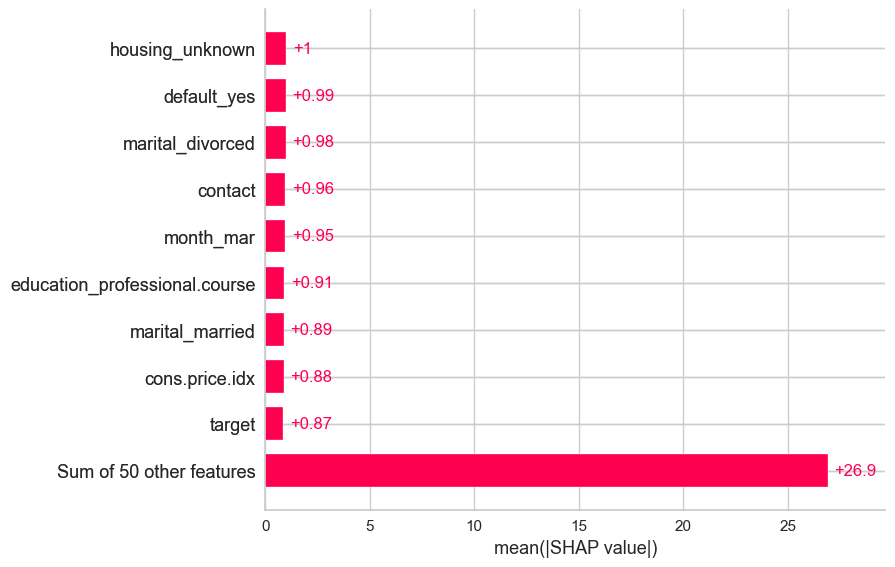

In [116]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(clf_xgb, X_train_sm)

# Compute SHAP values
shap_values = explainer.shap_values(X_val)

# Convert SHAP values to Explanation object with feature names
shap_explainer = shap.Explanation(X_val, shap_values, feature_names=df.columns)

# Plot the bar plot
shap.plots.bar(shap_explainer)

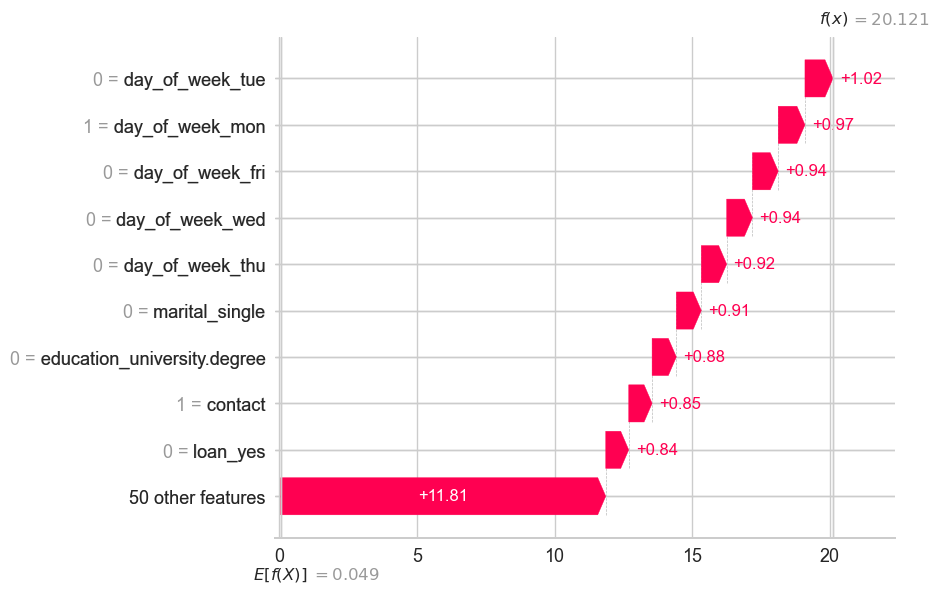

In [121]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [122]:
shap.initjs()

In [123]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [126]:
# visualize some training set predictions
shap.plots.force(shap_values[:500])

# Explainability - LIME

In [ ]:
#pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ----------- --------------------------- 81.9/275.7 kB 2.3 MB/s eta 0:00:01
     -------------------------- ----------- 194.6/275.7 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=ba08d56de36feb0da8cce6b0fe4021562a84f973940d01c0cde7ef223ef484a4
  Stored in directory: c:\users\olivi\appdata\local\pip\cache\wheels\fd\a2\af\9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [127]:
import lime
import lime.lime_tabular

# Create a LimeTabularExplainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_sm,
    feature_names=list(df.columns),
    class_names=['Not Subscribed', 'Subscribed'],
    discretize_continuous=True
)

In [130]:
# Choose an instance from your test data to explain
instance_idx = 5  # Choose the index of the instance you want to explain

# Get the prediction function for your XGBoost model
predict_fn = lambda x: clf_xgb.predict_proba(x).astype(float)

In [131]:
# Generate an explanation for the chosen instance
explanation = explainer.explain_instance(
    X_test[instance_idx],
    predict_fn,
    num_features=len(df.columns)
)

# Show the explanation
explanation.show_in_notebook()

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


# Data drift

We don't have any date feature (we have the months and days but not the years...), so we can't really analyze the changes in the distribution of input data over time to see make an analysis of its impact on model performance and reliability. However, for the sake of the project and so we can at least try, we did a KS test on some sample data.

#### Kolmogorov-Smirnov (KS) Test

In [132]:
# Ensure X_train has the same number of columns (excluding 'target') as the original DataFrame
X_train_subset = X_train[:, :len(df.columns) - 1]  # Exclude 'target' column

# Get column names excluding 'target'
column_names = df.drop(columns=['target']).columns

# Convert the subset of X_train to a DataFrame with column names
df_train = pd.DataFrame(X_train_subset, columns=column_names)

# Define df_val using the validation data
X_val_subset = X_val[:, :len(df.columns) - 1]  # Exclude 'target' column
df_val = pd.DataFrame(X_val_subset, columns=column_names)

In [133]:
from scipy.stats import ks_2samp

# Define the detect_drift function
def detect_drift(df_train, df_test, numeric_cols):
    drift_results = {}
    for col in numeric_cols:
        if col in df_train.columns and col in df_test.columns:
            statistic, p_value = ks_2samp(df_train[col], df_test[col])
            drift_results[col] = {'KS Statistic': statistic, 'P-value': p_value}
        else:
            print(f"Warning: Feature '{col}' is not present in both datasets.")
    return drift_results

In [134]:
# Detect drift between training and validation/test sets
drift_results_val = detect_drift(df_train, df_val, numeric_cols)
drift_results_test = detect_drift(df_train, pd.DataFrame(X_test, columns=df.columns[:-1]), numeric_cols)

In [135]:
# Display drift detection results
print("Drift detection results for validation set:")
for feature, result in drift_results_val.items():
    print(f"Feature: {feature}, KS Statistic: {result['KS Statistic']}, P-value: {result['P-value']}")

print("\nDrift detection results for test set:")
for feature, result in drift_results_test.items():
    print(f"Feature: {feature}, KS Statistic: {result['KS Statistic']}, P-value: {result['P-value']}")

Drift detection results for validation set:
Feature: age, KS Statistic: 0.012390533331969433, P-value: 0.4121388508055448
Feature: campaign, KS Statistic: 0.009500088587381716, P-value: 0.7442805116651354
Feature: pdays, KS Statistic: 0.004000737309314384, P-value: 0.9999970796033144
Feature: previous, KS Statistic: 0.0032619907448053764, P-value: 0.999999997897541
Feature: cons.price.idx, KS Statistic: 0.007236015413115249, P-value: 0.9508973963991567
Feature: cons.conf.idx, KS Statistic: 0.006340271729428193, P-value: 0.9859248995980135
Feature: nr.employed, KS Statistic: 0.006311829896866419, P-value: 0.9866004386322524

Drift detection results for test set:
Feature: age, KS Statistic: 0.005836811537885511, P-value: 0.9947493745144582
Feature: campaign, KS Statistic: 0.012463163164431301, P-value: 0.40481470698726363
Feature: pdays, KS Statistic: 0.0017750422153367529, P-value: 1.0
Feature: previous, KS Statistic: 0.0008515226960442712, P-value: 1.0
Feature: cons.price.idx, KS Stati

In [136]:
import pandas as pd

# Define the drift detection results
drift_detection_results = {
    'Feature': [],
    'KS Statistic (Validation Set)': [],
    'P-value (Validation Set)': [],
    'KS Statistic (Test Set)': [],
    'P-value (Test Set)': []
}

# Update drift_detection_results with validation set results
for feature, result in drift_results_val.items():
    drift_detection_results['Feature'].append(feature)
    drift_detection_results['KS Statistic (Validation Set)'].append(result['KS Statistic'])
    drift_detection_results['P-value (Validation Set)'].append(result['P-value'])

# Update drift_detection_results with test set results
for feature, result in drift_results_test.items():
    index = drift_detection_results['Feature'].index(feature)
    drift_detection_results['KS Statistic (Test Set)'].insert(index, result['KS Statistic'])
    drift_detection_results['P-value (Test Set)'].insert(index, result['P-value'])

# Create DataFrame
df_drift_detection_results = pd.DataFrame(drift_detection_results)

df_drift_detection_results


Feature  KS Statistic (Validation Set)  P-value (Validation Set)  \
0             age                       0.012391                  0.412139   
1        campaign                       0.009500                  0.744281   
2           pdays                       0.004001                  0.999997   
3        previous                       0.003262                  1.000000   
4  cons.price.idx                       0.007236                  0.950897   
5   cons.conf.idx                       0.006340                  0.985925   
6     nr.employed                       0.006312                  0.986600   

   KS Statistic (Test Set)  P-value (Test Set)  
0                 0.005837            0.994749  
1                 0.012463            0.404815  
2                 0.001775            1.000000  
3                 0.000852            1.000000  
4                 0.007258            0.949678  
5                 0.011380            0.521411  
6                 0.015078            0.195679

Statistical Significance: Using statistical tests, such as hypothesis testing, to determine whether the observed differences are statistically significant based on chosen significance levels (e.g., α = 0.05).

Overall, these results indicate that most features exhibit little to no drift between the training and validation sets and between the training and test sets. However, it’s essential to monitor any significant changes over time to ensure model performance remains consistent.